In [1]:
import numpy as np
import scipy
from scipy.linalg import expm
import random
import math
import cmath as cm
from scipy.stats import unitary_group
from scipy import linalg
import matplotlib.pyplot as plt
from scipy.optimize import minimize, curve_fit, basinhopping
import matplotlib
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.autograd.functional import jacobian, hessian
import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
import torch_optimizer

import os
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

import torch

In [2]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    


set_random_seed(42)
L.seed_everything(42)

Seed set to 42


42

In [3]:
torch.cuda.is_available()

True

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [5]:
def T_pq(N, p, q, phi, theta):
    T = np.eye(N,dtype=np.complex128)
    T[q,q]=cm.exp(1j*phi)*math.sin(theta)*1j*cm.exp(1j*theta*0.5) #with coefficient
    T[q,p]=cm.exp(1j*phi)*math.cos(theta)*1j*cm.exp(1j*theta*0.5)
    T[p,q]=math.cos(theta)*1j*cm.exp(1j*theta*0.5)
    T[p,p]=-math.sin(theta)*1j*cm.exp(1j*theta*0.5)
    return T

def Reck_extand(N, phases, phases_last):
    k=0
    U=np.eye(N, dtype=np.complex128)
    for p in range(1, N):
        for q in range(0, p):
            U=U.dot(T_pq(N, p, q, phases[k, 0], phases[k, 1])) #be aware of precise phase sequence!!!
            k+=1
    D=np.eye(N, dtype=np.complex128)
    for i in range(N-1):
        D[i,i]=cm.exp(1j*phases_last[i])
    U=U.dot(D)
#    return U
    return linalg.inv(U)

def Reck_decomposition_extand(weights, N):
    reck=weights
    phases=[]
    for i in range(1,N):
        for j in range(0, i):
            phi=cm.phase(reck[j,i])-cm.phase(reck[j,j])
            theta=math.atan(abs(reck[j,j])/abs(reck[j,i]))
            reck=reck.dot(T_pq(N,i,j,phi,theta))
            phases.append([phi,theta])
    phases=np.reshape(phases,[N*(N-1)//2,2])
    global_phase=cm.phase(reck[N-1,N-1])
    D=np.eye(N, dtype=complex)
    for i in range(N-1):
        D[i,i]=cm.exp(1j*(-cm.phase(reck[i,i])+global_phase))
    phases_last=[]
    for i in range(N-1):
        phases_last.append(cm.phase(D[i,i]))
    phases_last=np.array(phases_last)
    return phases, phases_last

def T_pq_torch(N, p, q, phi, theta, device):
    T = torch.eye(N, dtype=torch.complex128, device=device)
    T[q,q]=cm.exp(1j*phi)*math.sin(theta)*1j*cm.exp(1j*theta*0.5) #with coefficient
    T[q,p]=cm.exp(1j*phi)*math.cos(theta)*1j*cm.exp(1j*theta*0.5)
    T[p,q]=math.cos(theta)*1j*cm.exp(1j*theta*0.5)
    T[p,p]=-math.sin(theta)*1j*cm.exp(1j*theta*0.5)
    return T

def Reck_extand_torch(N, phases, device, phases_last=np.zeros(3)):
    k=0
    pairs = [[phases[i], phases[i+1]] for i in range(len(phases) - 1)]
    U=torch.eye(N, dtype=torch.complex128, device=device)
    for p in range(1, N):
        for q in range(0, p):
            U=U @ T_pq_torch(N, p, q, pairs[k][0], pairs[k][1], device)
            k+=1
    D=torch.eye(N, dtype=torch.complex128, device=device)
    for i in range(N-1):
        D[i,i]=cm.exp(1j*phases_last[i])
    U=U @ D
#    return U
    return torch.linalg.inv(U)

def Haar_Random_U(n):
    """A Random matrix distributed with Haar measure"""
    z = (np.random.randn(n, n) + 1j * np.random.randn(n, n)) / math.sqrt(2.0)
    q, r = linalg.qr(z)
    d = np.diagonal(r)
    ph = d / abs(d)
    q = np.multiply(q, ph, q)
    return q

def Is_unitary(m):
    return np.allclose(np.eye(m.shape[0]), m.H * m)

In [6]:
N=4
U=Haar_Random_U(N)
phases_dec, phases_last=Reck_decomposition_extand(U, N)
print(phases_dec)
print(phases_last)

[[ 1.69210351  1.42019338]
 [-3.04235561  0.80695366]
 [-3.41144987  0.18884714]
 [-2.36760614  0.85140468]
 [-1.13085447  1.35206587]
 [ 2.03457283  0.17690316]]
[ 3.06833141 -2.78603411 -2.59926268]


In [7]:
phases_dec, phases_last=Reck_decomposition_extand(U, N)
print(phases_dec)

phases_last = np.zeros(3)

print(phases_last)


U_reck=Reck_extand(N, phases_dec, phases_last)
U_reck=np.matrix(U_reck)
# FM(U, U_reck)
print(Is_unitary(U_reck))
print(U_reck)

[[ 1.69210351  1.42019338]
 [-3.04235561  0.80695366]
 [-3.41144987  0.18884714]
 [-2.36760614  0.85140468]
 [-1.13085447  1.35206587]
 [ 2.03457283  0.17690316]]
[0. 0. 0.]
True
[[-0.4408985 -0.30670157j  0.05429698-0.06078343j -0.01683892-0.52003009j
  -0.27211093-0.60011722j]
 [ 0.52228223+0.47600289j -0.06651143+0.25469526j -0.10492544-0.6274539j
   0.07378421-0.14559265j]
 [-0.34172058-0.01907895j  0.13047326-0.21267761j -0.45156578-0.30695395j
   0.67109826+0.26851956j]
 [ 0.25304131+0.17612018j  0.41666141-0.82957941j  0.14923864-0.0645977j
  -0.11997354-0.04800376j]]


In [8]:
data = []
data_no_current = []
for ch in range(4):
    for H in range(3):
        with open(f"Calibration Example_915\ch{ch + 1}_H{H + 1}.txt") as file:
            for line in file:
                try:
                    row = [float(num) for num in line.split()]
                    # if row[0] % 10 == 0:
                    #     data.append([ch,H] + row)
                    if row[0] < 420:
                        if row[0] % 40 == 0:
                            data.append([ch,H] + row)
                    else:
                        continue
                    if row[0] == 0:
                        data_no_current.append([ch,H] + row)
                except:
                    pass

def create_un_mat_torch(v, device):

    Mc = torch.zeros((4, 4), dtype=torch.complex128, device=device)

    Mc[0, 1] = v[0] + 1j * v[1]
    Mc[1, 0] = v[0] - 1j * v[1]

    Mc[0, 2] = v[2] + 1j * v[3]
    Mc[2, 0] = v[2] - 1j * v[3]

    Mc[0, 3] = v[4] + 1j * v[5]
    Mc[3, 0] = v[4] - 1j * v[5]

    Mc[1, 2] = v[6] + 1j * v[7]
    Mc[2, 1] = v[6] - 1j * v[7]

    Mc[1, 3] = v[8] + 1j * v[9]
    Mc[3, 1] = v[8] - 1j * v[9]

    Mc[2, 3] = v[10] + 1j * v[11]
    Mc[3, 2] = v[10] - 1j * v[11]

    U_torch = torch.matrix_exp(1j * Mc)
    return U_torch

def create_un_mat_numpy(v):
    Mc = np.zeros((4, 4),dtype=np.complex128)
    Mc[0][1] = v[0] + 1j * v[1]
    Mc[1][0] = v[0] - 1j * v[1]
    
    Mc[0][2] = v[2] + 1j * v[3]
    Mc[2][0] = v[2] - 1j * v[3]
    
    Mc[0][3] = v[4] + 1j * v[5]
    Mc[3][0] = v[4] - 1j * v[5]

    Mc[1][2] = v[6] + 1j * v[7]
    Mc[2][1] = v[6] - 1j * v[7]

    Mc[1][3] = v[8] + 1j * v[9]
    Mc[3][1] = v[8] - 1j * v[9]

    Mc[2][3] = v[10] + 1j * v[11]
    Mc[3][2] = v[10] - 1j * v[11]
    
    U = expm(1j * Mc)
    
    return U

def f_torch(v, data):

    M1 = create_un_mat_torch(v[:12], device=device)
    M2 = create_un_mat_torch(v[12:24], device=device)

    alpha = v[24:33].reshape(3, 3)
    h_0 = v[33:36]

    current_coefficient = 0.005

    cost = torch.tensor(0.0, dtype=torch.float32, device=device)

    for i in data:
        x = torch.zeros(3, dtype=torch.float32, device=device)
        x[i[1]] = (current_coefficient * i[2]) ** 2
        y = torch.tensor(i[3:], dtype=torch.complex128, device=device)
        y /= torch.sum(y)

        h_list = h_0 + alpha @ x
        H_diag = torch.cat([
            torch.exp(1j * h_list),
            torch.tensor([1.0], dtype=torch.complex128, device=device)
        ])
        H = torch.diag(H_diag)
        predict = torch.abs((M2 @ H @ M1).T) ** 2
        cost += torch.norm(predict[i[0]] - y)
    return cost

def f_torch_no_data(v, data=data):

    M1 = create_un_mat_torch(v[:12], device=device)
    M2 = create_un_mat_torch(v[12:24], device=device)

    alpha = v[24:33].reshape(3, 3)
    h_0 = v[33:36]
    cost = torch.tensor(0.0, dtype=torch.double, device=device)

    current_coefficient = 0.005

    for i in data:
        x = torch.zeros(3, dtype=torch.double, device=device)
        x[i[1]] = (current_coefficient * i[2]) ** 2
        y = torch.tensor(i[3:], dtype=torch.complex128, device=device)
        y /= torch.sum(y)

        h_list = h_0 + alpha @ x
        H_diag = torch.cat([
            torch.exp(1j * h_list),
            torch.tensor([1.0], dtype=torch.complex128, device=device)
        ])
        H = torch.diag(H_diag)
        predict = torch.abs((M2 @ H @ M1).T) ** 2
        cost += torch.norm(predict[i[0]] - y)
    return cost

def f_torch_no_data_Reck(v, data=data):

    M1 =  Reck_extand_torch(4, v[:12], device=device)
    M2 =  Reck_extand_torch(4, v[12:24], device=device)

    alpha = v[24:33].reshape(3, 3)
    h_0 = v[33:36]
    cost = torch.tensor(0.0, dtype=torch.double, device=device)

    for i in data:
        x = torch.zeros(3, dtype=torch.double, device=device)
        x[i[1]] = 10**(-4) * i[2] ** 2
        y = torch.tensor(i[3:], dtype=torch.complex128, device=device)
        y /= torch.sum(y)

        h_list = h_0 + alpha @ x
        H_diag = torch.cat([
            torch.exp(1j * h_list),
            torch.tensor([1.0], dtype=torch.complex128, device=device)
        ])
        H = torch.diag(H_diag)
        predict = torch.abs((M2 @ H @ M1).T) ** 2
        cost += torch.norm(predict[i[0]] - y)
    return cost

def f_numpy_no_data(v, data=data):
    M1 = create_un_mat_numpy(v[:12])
    M2 = create_un_mat_numpy(v[12:24])
    alpha = np.reshape(v[24:33], (3, 3))
    h_0 = v[33:36]
    current_coefficient = 0.005

    cost = 0
    for i in data:
        x = np.zeros(3)
        x[i[1]] = (current_coefficient * i[2]) ** 2
        y = i[3:]
        y /= np.sum(y)
        h_list = h_0 + alpha.dot(np.transpose(x))
        H = np.diag([math.e ** (1j * h) for h in h_list] + [1])
        predict = (np.abs(np.transpose(M2.dot(H).dot(M1)))** 2)[i[0]]
        cost += np.linalg.norm(np.array(predict) - y)
    return cost

def f_numpy_no_data_Reck(v, data=data):
    M1 = Reck_extand(4, v[:12])
    M2 = Reck_extand(4, v[12:24])
    alpha = np.reshape(v[24:33], (3, 3))
    h_0 = v[33:36]
    cost = 0
    for i in data:
        x = np.zeros(3)
        x[i[1]] = 10**(-4) * i[2] ** 2
        y = i[3:]
        y /= np.sum(y)
        h_list = h_0 + alpha.dot(np.transpose(x))
        H = np.diag([math.e ** (1j * h) for h in h_list] + [1])
        predict = (np.abs(np.transpose(M2.dot(H).dot(M1)))** 2)[i[0]]
        cost += np.linalg.norm(np.array(predict) - y)
    return cost

def f_numpy_no_data_no_current(v, data=data_no_current):
    M1 = create_un_mat_numpy(v[:12])
    M2 = create_un_mat_numpy(v[12:24])
    alpha = np.reshape(v[24:33], (3, 3))
    h_0 = v[33:36]
    cost = 0
    for i in data:
        x = np.zeros(3)
        x[i[1]] = 10**(-4) * i[2] ** 2
        y = i[3:]
        y /= np.sum(y)
        h_list = h_0 + alpha.dot(np.transpose(x))
        H = np.diag([math.e ** (1j * h) for h in h_list] + [1])
        predict = (np.abs(np.transpose(M2.dot(H).dot(M1)))** 2)[i[0]]
        cost += np.linalg.norm(np.array(predict) - y)
    return cost

def f_torch_no_data_no_current(v, data=data_no_current):

    M1 = create_un_mat_torch(v[:12], device=device)
    M2 = create_un_mat_torch(v[12:24], device=device)

    # alpha = v[24:33].reshape(3, 3)
    h_0 = v[33:36]
    cost = torch.tensor(0.0, dtype=torch.double, device=device)

    for i in data:
        x = torch.zeros(3, dtype=torch.double, device=device)
        x[i[1]] = 10**(-4) * i[2] ** 2
        y = torch.tensor(i[3:], dtype=torch.complex128, device=device)
        y /= torch.sum(y)

        h_list = h_0 #+ alpha @ x
        H_diag = torch.cat([
            torch.exp(1j * h_list),
            torch.tensor([1.0], dtype=torch.complex128, device=device)
        ])
        H = torch.diag(H_diag)
        predict = torch.abs((M2 @ H @ M1).T) ** 2
        cost += torch.norm(predict[i[0]] - y)
    return cost

def build_function(v, data=data_no_current):
    M1 = create_un_mat_numpy(v[:12])
    M2 = create_un_mat_numpy(v[12:24])
    # alpha = np.reshape(v[24:33], (3, 3))
    h_0 = v[33:36]
    cost = 0
    predict = []
    y_list = []
    for i in data:
        x = np.zeros(3)
        x[i[1]] = 10**(3) * i[2] ** 2
        y = i[3:]
        y /= np.sum(y)
        h_list = h_0 #+ alpha.dot(np.transpose(x))
        H = np.diag([math.e ** (1j * h) for h in h_list] + [1])
        predict.append((np.abs(np.transpose(M2.dot(H).dot(M1)))** 2)[i[0]])
        y_list.append(y)
    return predict, y_list

In [9]:
x0 = np.random.random(36)
print(x0)

def f_hessian(x, f):
    x0_torch = torch.from_numpy(x).to(device)
    x0_torch.requires_grad = True
    x0_torch = x0_torch.double()
    H = hessian(f, x0_torch)
    return H.to('cpu').numpy()

def f_jacobian(x, f):
    x0_torch = torch.from_numpy(x).to(device)
    x0_torch.requires_grad = True
    x0_torch = x0_torch.double()
    J = jacobian(f, x0_torch)
    return J.to('cpu').numpy()

def f_minimize(x0, *args):
    return f_numpy_no_data(x0)

result = minimize(
    f_minimize,
    x0,
    args=(f_torch_no_data),
    method='Newton-CG',
    jac=f_jacobian,
    hess=f_hessian,
    options={'disp': True}
)

# result_basinhop = basinhopping(
#     f_minimize,
#     x0,
#     niter=100,
#     T=2.0,
#     stepsize=0.9,
#     minimizer_kwargs={"method": "Newton-CG", "jac": f_jacobian, "hess": f_hessian, "args": (f_torch_no_data)},
# )

[0.12203823 0.49517691 0.03438852 0.9093204  0.25877998 0.66252228
 0.31171108 0.52006802 0.54671028 0.18485446 0.96958463 0.77513282
 0.93949894 0.89482735 0.59789998 0.92187424 0.0884925  0.19598286
 0.04522729 0.32533033 0.38867729 0.27134903 0.82873751 0.35675333
 0.28093451 0.54269608 0.14092422 0.80219698 0.07455064 0.98688694
 0.77224477 0.19871568 0.00552212 0.81546143 0.70685734 0.72900717]


KeyboardInterrupt: 

In [118]:
result_basinhop

                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 193.0581587626925
                          x: [ 1.258e+00  1.563e+00 ...  1.290e-01
                               6.781e-01]
                        nit: 100
      minimization_failures: 0
                       nfev: 247
                       njev: 247
                       nhev: 109
 lowest_optimization_result: message: Optimization terminated successfully.
                             success: True
                              status: 0
                                 fun: 193.0581587626925
                                   x: [ 1.258e+00  1.563e+00 ...  1.290e-01
                                        6.781e-01]
                                 nit: 1
                                 jac: [ 8.980e+00  1.074e+01 ... -3.605e+00
                                       -8.526e-01]
                                nfev: 

In [ ]:
seed = 42
torch.manual_seed(seed)
if device == "cuda":
    torch.cuda.manual_seed(seed)

x0 = nn.Parameter(torch.randn(37, dtype=torch.float32, device=device), requires_grad=True)
# optimizer = optim.Adam([x0], lr=0.3)
optimizer = torch_optimizer.Adahessian([x0])
# U = create_un_mat(x0, device=device)
scheduler = CosineAnnealingLR(optimizer, T_max=100)

print(x0)

In [ ]:
def f(x):
    return torch.stack([
        x[0]**2 + x[1],
        torch.sin(x[0] * x[1])
    ])

# Input point (requires grad)
x = torch.tensor([1.0, 2.0], requires_grad=True)

# Compute the Jacobian
J = jacobian(f, x)

print("Jacobian:\n", J)

In [ ]:
x0_optimized = x0.clone()
print(x0_optimized)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/ex1 --port 6011

In [ ]:
x0 = np.random.random(36)


def f_hessian(x, f):
    x0_torch = torch.from_numpy(x).to(device)
    x0_torch.requires_grad = True
    x0_torch = x0_torch.double()
    H = hessian(f, x0_torch)
    return H.to('cpu').numpy()

def f_jacobian(x, f):
    x0_torch = torch.from_numpy(x).to(device)
    x0_torch.requires_grad = True
    x0_torch = x0_torch.double()
    J = jacobian(f, x0_torch)
    return J.to('cpu').numpy()

In [ ]:
x0 = np.random.random(36)

result_basinhop = basinhopping(
    f_numpy_no_data,
    x0,
    niter=6,
    T=1.0,
    stepsize=0.5,
    minimizer_kwargs={"method": "Newton-CG", "jac": f_jacobian, "hess": f_hessian},
    # callback=lambda x, f: print(f"Current point: {x}, function value: {f}"),
)

In [ ]:
# x0 = np.random.random(36)

def f_hessian_no_current(x, f=f_torch_no_data_no_current):
    x0_torch = torch.from_numpy(x).to(device)
    x0_torch.requires_grad = True
    x0_torch = x0_torch.double()
    H = hessian(f, x0_torch)
    return H.to('cpu').numpy()

def f_jacobian_no_current(x, f=f_torch_no_data_no_current):
    x0_torch = torch.from_numpy(x).to(device)
    x0_torch.requires_grad = True
    x0_torch = x0_torch.double()
    J = jacobian(f, x0_torch)
    return J.to('cpu').numpy()

result = minimize(
    f_numpy_no_data_no_current,
    x0,
    method='Newton-CG',
    jac=f_jacobian,
    hess=f_hessian,
    options={'disp': True}
)

In [67]:
seed = 42
torch.manual_seed(seed)
if device == "cuda":
    torch.cuda.manual_seed(seed)

x0 = nn.Parameter(torch.randn(37, dtype=torch.float32, device=device), requires_grad=True)
optimizer =  torch.optim.LBFGS([x0], lr=1)#optim.Adam([x0])
with torch.no_grad():
     x0[36].fill_(1e-2)
# optimizer = torch_optimizer.Adahessian([x0])
# U = create_un_mat(x0, device=device)
# scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=0.001)
print(x0)

Parameter containing:
tensor([ 0.1940,  2.1614, -0.1721,  0.8491, -1.9244,  0.6530, -0.6494, -0.8175,
         0.5280, -1.2753, -1.6621, -0.3033, -0.0926,  0.1992, -1.1204,  1.8577,
        -0.7145,  0.6881,  0.7968, -0.0334,  1.4917, -0.5165, -0.2541,  1.4746,
        -0.3260, -1.1600,  2.3551, -0.6924,  0.1837, -1.1835, -1.8029, -1.5808,
         0.8387,  1.4192,  0.6469,  0.4253,  0.0100], device='cuda:0',
       requires_grad=True)


In [ ]:
from torch.utils.tensorboard import SummaryWriter


min_loss = 1e10
steps = 100

seed = 42
torch.manual_seed(seed)
if device == "cuda":
    torch.cuda.manual_seed(seed)

def closure():
    optimizer.zero_grad()
    # loss = f_torch_no_data_no_current(x0, data_no_current)
    loss = f_torch(x0, data)
    loss.backward(create_graph=True)
    # torch.nn.utils.clip_grad_norm_(x0, max_norm=1.0)
    print(f"loss: {loss.item()}")
    if loss.item() < 1e-5:
        print("Converged")
    return loss

run_id = datetime.now().strftime("test")
log_dir = os.path.join("logs", "ex1", run_id)
writer = SummaryWriter(log_dir='logs/ex1')

for n in range(steps):
    print(f"Step {n + 1}/{steps}")
    optimizer.step(closure)
    # scheduler.step()
    print(x0.grad)

    with torch.no_grad():
        loss = f_torch(x0, data)
        writer.add_scalar("Loss/train", loss.item(), n)
        writer.add_scalar("Learning rate", scheduler.get_last_lr()[0], n)
        
    if n == steps - 1:
        print("Final loss:", closure().item())
        print("Final parameters:", x0.data.cpu().numpy())
        if loss.item() < min_loss:
            min_loss = loss.item()
            x0_optimized = x0.clone()
            print("Updated optimized parameters")
        # x0 = nn.Parameter(torch.randn(36, dtype=torch.float32, device=device), requires_grad=True)

writer.close()

In [ ]:
predict, y_list = build_function(x0.data.cpu().numpy(), data_no_current)
print(predict)
print(y_list)

In [ ]:
writer.close()

import shutil
shutil.rmtree("logs", ignore_errors=True)

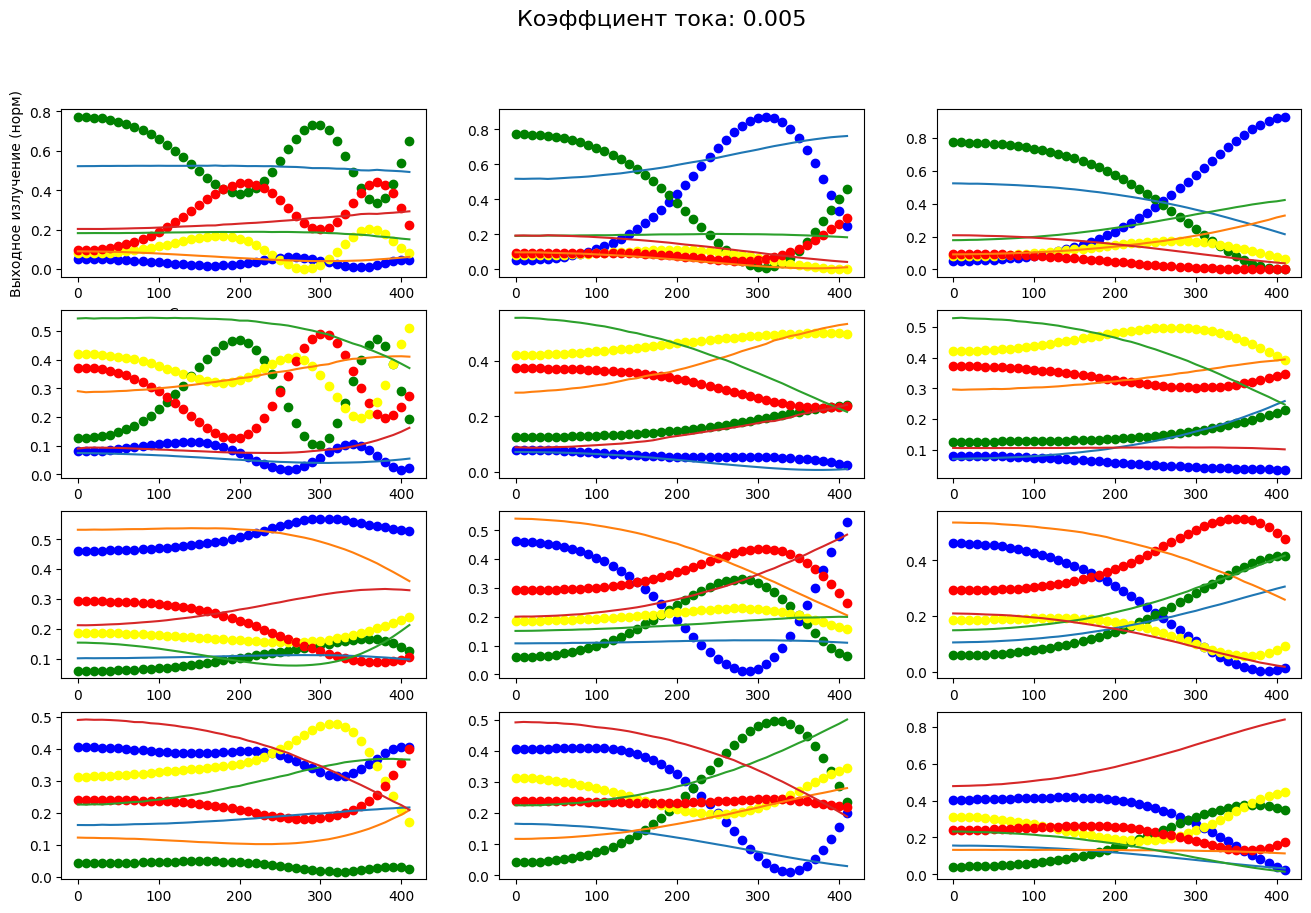

In [119]:
x0 = result_basinhop.x
# x0 = result_basinhop.x

M1 = create_un_mat_torch(x0[:12], device=device)
M2 = create_un_mat_torch(x0[12:24], device=device)
alpha = torch.tensor(x0[24:33], dtype=torch.complex128, device=device).reshape(3, 3)
h_0 = torch.tensor(x0[33:36], dtype=torch.complex128, device=device)

current_coefficient = 0.005

fig, ax = plt.subplots(4, 3, figsize=(16, 10))

for j in range(4):
    for k in range(3):

        # for i in data[131*(3*j+k):131*(3*j+k+1)]:
        for i in data[42*(3*j+k):42*(3*j+k+1)]:
            x = torch.zeros(3, dtype=torch.complex128, device=device)
            x[i[1]] = (current_coefficient * i[2]) ** 2
            y = torch.tensor(i[3:], dtype=torch.complex128, device=device)
            y /= torch.sum(y)

            h_list = h_0 + alpha @ x
            H_diag = torch.cat([torch.exp(1j * h_list), torch.tensor([1.0], dtype=torch.complex64, device=device)])
            H = torch.diag(H_diag)
            result_plot = (torch.abs((M2 @ H @ M1).T) ** 2)[i[0]]
            ax[j][k].scatter(i[2], result_plot[0].cpu().detach().numpy(), color = 'blue')
            ax[j][k].scatter(i[2], result_plot[1].cpu().detach().numpy(), color = 'green')
            ax[j][k].scatter(i[2], result_plot[2].cpu().detach().numpy(), color = 'yellow')
            ax[j][k].scatter(i[2], result_plot[3].cpu().detach().numpy(), color = 'red')

        # ax[j][k].plot([d[2] for d in data[131*(3*j+k):131*(3*j+k+1)]], [d[3]/sum(d[3:]) for d in data[131*(3*j+k):131*(3*j+k+1)]])#, color = 'blue')
        # ax[j][k].plot([d[2] for d in data[131*(3*j+k):131*(3*j+k+1)]], [d[4]/sum(d[3:]) for d in data[131*(3*j+k):131*(3*j+k+1)]])#, color = 'green')
        # ax[j][k].plot([d[2] for d in data[131*(3*j+k):131*(3*j+k+1)]], [d[5]/sum(d[3:]) for d in data[131*(3*j+k):131*(3*j+k+1)]])#, color = 'yellow')
        # ax[j][k].plot([d[2] for d in data[131*(3*j+k):131*(3*j+k+1)]], [d[6]/sum(d[3:]) for d in data[131*(3*j+k):131*(3*j+k+1)]])#, color = 'red')

        ax[j][k].plot([d[2] for d in data[42*(3*j+k):42*(3*j+k+1)]], [d[3]/sum(d[3:]) for d in data[42*(3*j+k):42*(3*j+k+1)]])#, color = 'blue')
        ax[j][k].plot([d[2] for d in data[42*(3*j+k):42*(3*j+k+1)]], [d[4]/sum(d[3:]) for d in data[42*(3*j+k):42*(3*j+k+1)]])#, color = 'green')
        ax[j][k].plot([d[2] for d in data[42*(3*j+k):42*(3*j+k+1)]], [d[5]/sum(d[3:]) for d in data[42*(3*j+k):42*(3*j+k+1)]])#, color = 'yellow')
        ax[j][k].plot([d[2] for d in data[42*(3*j+k):42*(3*j+k+1)]], [d[6]/sum(d[3:]) for d in data[42*(3*j+k):42*(3*j+k+1)]])#, color = 'red')

        ax[0][0].set_xlabel('Сила тока, единицы')
        ax[0][0].set_ylabel('Выходное излучение (норм)')

        fig.suptitle('Фитирование данных Ильи с помощью нашего кода')
        fig.suptitle('Коэффциент тока: ' + str(current_coefficient), fontsize=16)


plt.show()

In [ ]:
result.x